In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, train_filenames= load_training()
test_images, test_labels, test_filenames= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2864 	 Test size: 704
Image size: 256x256


In [4]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [5]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [6]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [8]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [9]:
def create_vgg19(verbose=False, fc_size=256, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(2, activation='softmax'))

    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [17]:
vgg19_calc_or_mass_best = create_vgg19(dropout=0.5, fc_size=128)

In [18]:
vgg19_calc_or_mass_best.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 33,686,914
Non-trainable params: 20,024,384
_________________________________

In [19]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_vgg19_calc_or_mass_best = vgg19_calc_or_mass_best.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1928 - accuracy: 0.5749
Epoch 00001: val_loss improved from inf to 0.90245, saving model to ../model/vgg19_calc_or_mass_best.h5
11/11 [==============================] - 24s 2s/step - loss: 1.1655 - accuracy: 0.5831 - val_loss: 0.9024 - val_accuracy: 0.6154
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0073 - accuracy: 0.6219
Epoch 00002: val_loss improved from 0.90245 to 0.73201, saving model to ../model/vgg19_calc_or_mass_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.0137 - accuracy: 0.6229 - val_loss: 0.7320 - val_accuracy: 0.6748
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9037 - accuracy: 0.6538
Epoch 00003: val_loss improved from 0.73201 to 0.72902, saving model to ../mod

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5524 - accuracy: 0.7792
Epoch 00027: val_loss did not improve from 0.45772
11/11 [==============================] - 20s 2s/step - loss: 0.5554 - accuracy: 0.7801 - val_loss: 0.5169 - val_accuracy: 0.7640
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5607 - accuracy: 0.7914
Epoch 00028: val_loss did not improve from 0.45772
11/11 [==============================] - 21s 2s/step - loss: 0.5499 - accuracy: 0.7912 - val_loss: 0.4593 - val_accuracy: 0.8164
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5196 - accuracy: 0.7737
Epoch 00029: val_loss improved from 0.45772 to 0.44807, saving model to ../model/vgg19_calc_or_mass_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.5179 - accuracy: 0.7722 - val_loss: 0.4481 - val_accuracy: 0.8129
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5593 - accuracy: 0.7768
Epoch 00030: val_lo

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4951 - accuracy: 0.7831
Epoch 00056: val_loss did not improve from 0.37825
11/11 [==============================] - 21s 2s/step - loss: 0.4905 - accuracy: 0.7851 - val_loss: 0.3963 - val_accuracy: 0.8427
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4281 - accuracy: 0.8203
Epoch 00057: val_loss did not improve from 0.37825
11/11 [==============================] - 21s 2s/step - loss: 0.4449 - accuracy: 0.8075 - val_loss: 0.4025 - val_accuracy: 0.8129
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4381 - accuracy: 0.7953
Epoch 00058: val_loss did not improve from 0.37825
11/11 [==============================] - 22s 2s/step - loss: 0.4467 - accuracy: 0.7955 - val_loss: 0.3873 - val_accuracy: 0.8304
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4376 - accuracy: 0.8039
Epoch 00059: val_loss did not improve from 0.37825
11/11 [==================

Epoch 85/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4435 - accuracy: 0.8115
Epoch 00085: val_loss did not improve from 0.35181
11/11 [==============================] - 22s 2s/step - loss: 0.4406 - accuracy: 0.8123 - val_loss: 0.3749 - val_accuracy: 0.8199
Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4066 - accuracy: 0.8304
Epoch 00086: val_loss improved from 0.35181 to 0.34863, saving model to ../model/vgg19_calc_or_mass_best.h5
11/11 [==============================] - 23s 2s/step - loss: 0.4067 - accuracy: 0.8281 - val_loss: 0.3486 - val_accuracy: 0.8409
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4351 - accuracy: 0.8107
Epoch 00087: val_loss did not improve from 0.34863
11/11 [==============================] - 22s 2s/step - loss: 0.4346 - accuracy: 0.8109 - val_loss: 0.3877 - val_accuracy: 0.8357
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4342 - accuracy: 0.8094
Epoch 00088: val_lo

10/11 [==========================>...] - ETA: 1s - loss: 0.4069 - accuracy: 0.8188
Epoch 00143: val_loss improved from 0.32649 to 0.31981, saving model to ../model/vgg19_calc_or_mass_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.4040 - accuracy: 0.8188 - val_loss: 0.3198 - val_accuracy: 0.8601
Epoch 144/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4027 - accuracy: 0.8328
Epoch 00144: val_loss did not improve from 0.31981
11/11 [==============================] - 22s 2s/step - loss: 0.3927 - accuracy: 0.8345 - val_loss: 0.3437 - val_accuracy: 0.8409
Epoch 145/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3704 - accuracy: 0.8407
Epoch 00145: val_loss did not improve from 0.31981
11/11 [==============================] - 22s 2s/step - loss: 0.3699 - accuracy: 0.8388 - val_loss: 0.3677 - val_accuracy: 0.8444
Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3895 - accuracy: 0.8312
Epoch 00146: val_loss did not

Epoch 173/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3495 - accuracy: 0.8398
Epoch 00173: val_loss did not improve from 0.31981
11/11 [==============================] - 22s 2s/step - loss: 0.3594 - accuracy: 0.8338 - val_loss: 0.3402 - val_accuracy: 0.8601
Epoch 00173: early stopping


In [21]:
models.save_model(vgg19_calc_or_mass_best, '../model/vgg19_calc_or_mass_end.h5')

In [22]:
tra_loss_fe = history_vgg19_calc_or_mass_best.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best.history['accuracy']
val_loss_fe = history_vgg19_calc_or_mass_best.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best.history['val_accuracy']

In [23]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [24]:
print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 173
Epoch [opt]: 143
Valid accuracy [end]: 0.8601
Valid accuracy [opt]: 0.8601
Test accuracy [end]:  0.8381
Test accuracy [opt]:  0.8409
Valid loss [end]: 0.3402
Valid loss [opt]: 0.3198
Test loss [end]:  0.4038
Test loss [opt]:  0.4064


#### fine tuning

In [10]:
vgg19_calc_or_mass_1 = models.load_model('../model/vgg19_calc_or_mass_best.h5')

for layer in vgg19_calc_or_mass_1.get_layer('vgg19').layers:
    if layer.name.startswith('block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_1.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_calc_or_mass_1.summary()
vgg19_calc_or_mass_1.get_layer('vgg19').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 36,046,722
Non-trainable params: 17,664,576
_________________________________

In [11]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_1_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True, 
        save_freq='epoch')

In [12]:
history_fit = vgg19_calc_or_mass_1.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0306 - accuracy: 0.7164
Epoch 00001: val_loss improved from inf to 0.47412, saving model to ../model/vgg19_calc_or_mass_1_best.h5
11/11 [==============================] - 24s 2s/step - loss: 0.9802 - accuracy: 0.7223 - val_loss: 0.4741 - val_accuracy: 0.7937
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5185 - accuracy: 0.7737
Epoch 00002: val_loss improved from 0.47412 to 0.41306, saving model to ../model/vgg19_calc_or_mass_1_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.5205 - accuracy: 0.7722 - val_loss: 0.4131 - val_accuracy: 0.8094
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4400 - accuracy: 0.8070
Epoch 00003: val_loss improved from 0.41306 to 0.40687, saving model to ..

10/11 [==========================>...] - ETA: 1s - loss: 0.3484 - accuracy: 0.8494
Epoch 00027: val_loss did not improve from 0.29162
11/11 [==============================] - 22s 2s/step - loss: 0.3455 - accuracy: 0.8503 - val_loss: 0.3171 - val_accuracy: 0.8514
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3217 - accuracy: 0.8648
Epoch 00028: val_loss did not improve from 0.29162
11/11 [==============================] - 22s 2s/step - loss: 0.3243 - accuracy: 0.8651 - val_loss: 0.3289 - val_accuracy: 0.8671
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3244 - accuracy: 0.8691
Epoch 00029: val_loss did not improve from 0.29162
11/11 [==============================] - 22s 2s/step - loss: 0.3213 - accuracy: 0.8711 - val_loss: 0.3172 - val_accuracy: 0.8549
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3154 - accuracy: 0.8648
Epoch 00030: val_loss did not improve from 0.29162
11/11 [==============================]

10/11 [==========================>...] - ETA: 1s - loss: 0.2776 - accuracy: 0.8754
Epoch 00056: val_loss did not improve from 0.26564
11/11 [==============================] - 22s 2s/step - loss: 0.2732 - accuracy: 0.8804 - val_loss: 0.3021 - val_accuracy: 0.8881
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2669 - accuracy: 0.8875
Epoch 00057: val_loss did not improve from 0.26564
11/11 [==============================] - 22s 2s/step - loss: 0.2649 - accuracy: 0.8878 - val_loss: 0.3666 - val_accuracy: 0.8724
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3084 - accuracy: 0.8707
Epoch 00058: val_loss did not improve from 0.26564
11/11 [==============================] - 22s 2s/step - loss: 0.3143 - accuracy: 0.8689 - val_loss: 0.2858 - val_accuracy: 0.8934
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2787 - accuracy: 0.8805
Epoch 00059: val_loss did not improve from 0.26564
11/11 [==============================]

In [16]:
models.save_model(vgg19_calc_or_mass_1, '../model/vgg19_calc_or_mass_1_end.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['accuracy']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_1 = models.load_model('../model/vgg19_calc_or_mass_1_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_1.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 83
Epoch [opt]: 53
Valid accuracy [end]: 0.8724
Valid accuracy [opt]: 0.8811
Test accuracy [end]:  0.8693
Test accuracy [opt]:  0.8608
Valid loss [end]: 0.3280
Valid loss [opt]: 0.2656
Test loss [end]:  0.3715
Test loss [opt]:  0.3504


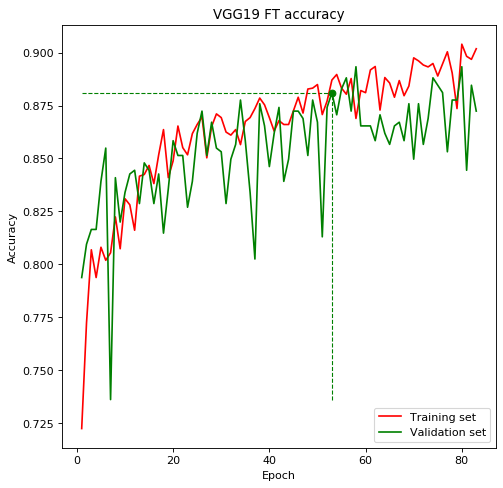

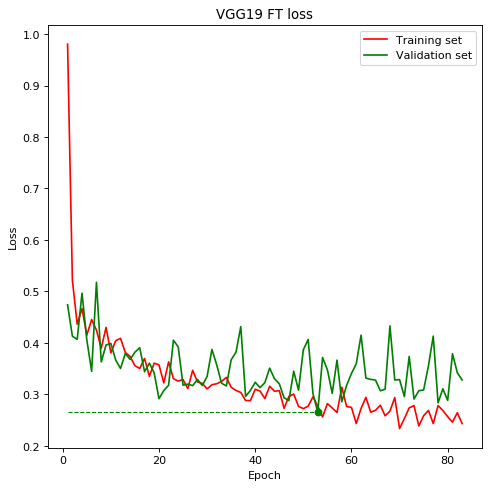

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();